## 순환신경망_시계열데이터_온도예측

### 데이터 불러오기

In [5]:
#파일 경로 지정 후 읽어오기
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

In [6]:
# culumns(header)부분과 내용(lines)구분하기
lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [8]:
import numpy as np

# 데이터 구분해서 저장
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header)-1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

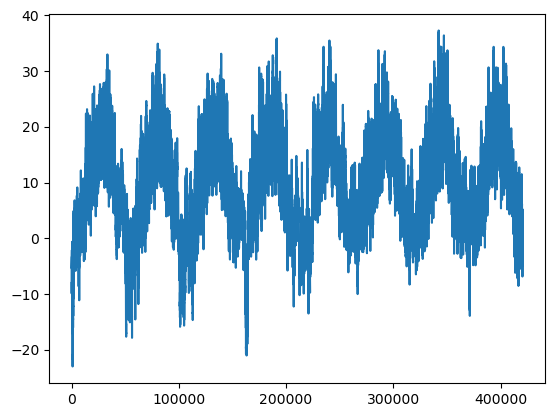

In [10]:
#그래프로 확인
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

In [11]:
# pandas로 불러오기

import pandas as pd
jena = pd.read_csv('jena_climate_2009_2016.csv')

temp = jena['T (degC)'].values
raw = jena.iloc[:,1:].values

In [12]:
#데이터 분리: 훈련/검증/테스트
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [14]:
#데이터 정규화

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [15]:
#데이터 세트 만들기
import keras

sampling_rate = 6    # 시간당 1개만 사용(데이터가 10분단위)
sequence_length = 120    # 5일 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 
  
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [16]:
#데이터셋 확인
for samples,targets in train_dataset:
    print('samples:', samples.shape)
    print('targets:', targets.shape)
    break


samples: (256, 120, 14)
targets: (256,)


In [21]:
#상식수준의 기준점 제시
# 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정
# 상식수준: 지금온도 = 24시간후 온도
# 평가방법: 평균절대값오차(MAE)
def evaluate_naive_method(dataset):
    total_mae = 0.
    samples_seen = 0.
    for samples, targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1]
        # 온도특성: sample 인덱스 1번 / samples[:,-1,1]: 입력 시퀀스의 마지막 온도측정값
        # 특성을 정규화 했으므로 다시 표준편차를 곱하고 평균을 나눔
        # std = raw_data[:num_train_samples].std(axis=0)
        # mean = raw_data[:num_train_samples].mean(axis=0)

        total_mae += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
  
        return total_mae / samples_seen

print(f'검증 mae: {evaluate_naive_method(val_dataset):.2f}')
print(f'테스트 mae: {evaluate_naive_method(test_dataset):.2f}')

검증 mae: 2.29
테스트 mae: 2.66


In [22]:
#온도 예측 여러방법
#기본 딥러닝

from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/10


819/819 [==============================] - 6s 6ms/step - loss: 13.3950 - mae: 2.8347 - val_loss: 10.6672 - val_mae: 2.5738
Epoch 2/10
819/81

In [23]:
#1D합성곱 모델 활용: Conv1D

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 초기 윈도우 24, 한번에 24시간의 데이터를 살핌
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392

In [24]:
#순환신경망 활용: LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 32s 37ms/step - loss: 46.6671 - mae: 5.0141 - val_loss: 13.8557 - val_mae: 2.8017
Epoch 2/10
819/819 [==============================] - 31s 37ms/step - loss: 11.4729 - mae: 2.6307 - val_loss: 9.7507 - val_mae: 2.4349
Epoch 3/10
819/819 [

In [25]:
#스태킹순환층활용: SimpleRNN / GRU

#SimpleRNN

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacking_rnn.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacking_rnn.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 120, 16)           496       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1041 (4.07 KB)
Trainable params: 1041 (4.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
819/819 [==============================] - 24s 27ms/step - loss: 41.8470 - mae: 4.6929 - val_loss: 13.2651 - val_mae: 2.7219
Epoch 2/10
819/819 [===

In [29]:
#GRU

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru_4 (GRU)                 (None, 120, 32)           4608      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10977 (42.88 KB)
Trainable params: 10977 (42.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
819/819 [===

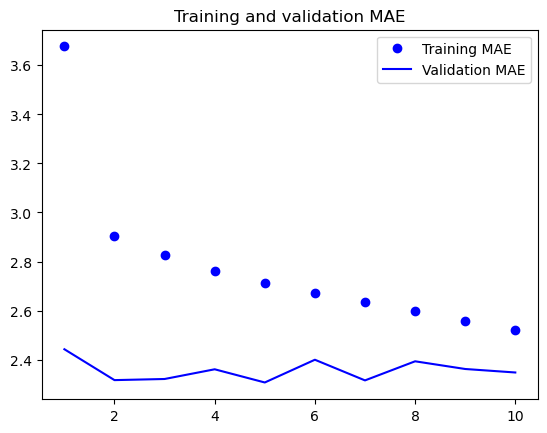

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 예측된 온도 데이터
predicted_temperature = model.predict(x_test)  # 모델에서 예측한 테스트 데이터의 결과

# 테스트 데이터의 실제 온도 데이터
actual_temperature = y_test  # y_test는 실제 테스트 데이터의 레이블(실제 온도)일 것으로 가정합니다

# 시간 정보 (예를 들어, 1부터 시작하는 인덱스를 사용한다고 가정)
time_steps = np.arange(1, len(predicted_temperature) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(time_steps, actual_temperature, label='Actual Temperature', marker='o')
plt.plot(time_steps, predicted_temperature, label='Predicted Temperature', marker='x')

plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()


NameError: name 'x_test' is not defined

In [ ]:
# 순환신경망+드롭아웃: LSTM + Dropout


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
#양방향 순환층: Bidirectional


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_bidirectional.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

